In [3]:
# %load ./Solution/database.py
import psycopg2
import glob
import os
import pandas as pd
from io import StringIO
from postgis.psycopg import register


def create_connection():
    host = os.environ['INFOCUP_PGHOST']
    port = os.environ['INFOCUP_PGPORT']
    return psycopg2.connect(f"host='{host}' port='{port}' dbname='infocup' user='infocup'")


def import_input():
    con = create_connection()
    cursor = con.cursor()
    cursor.execute('truncate table stations cascade;')
    f = open(r'../Eingabedaten/Tankstellen.csv', 'r')
    cursor.copy_from(f, 'stations', sep=';')
    f.close()
    con.commit()
    os.chdir('../Eingabedaten/Benzinpreise')
    files = glob.glob('*.csv')
    counter = 0
    for price_file in files:
        station_id = int(os.path.splitext(price_file)[0])
        df = pd.read_csv(price_file, delimiter=';')
        df['station_id'] = station_id
        buf = StringIO()
        df.to_csv(buf, header=False, index=False)
        buf.seek(0)
        cursor.copy_from(buf, 'prices', sep=',', columns=('time_stamp', 'price', 'station_id'))
        con.commit()
        counter += 1
        if counter % 100 == 0:
            print(str(counter) + ' / ' + str(len(files)))
    con.close()
    print('done')


def get_highways():
    con = create_connection()
    register(con)
    cursor = con.cursor()
    cursor.execute("""select row_to_json(fc)::text
    from (select 'FeatureCollection' as type, array_to_json(array_agg(f)) as features
    from  
    (select 'Feature' as type, 
    (select l from (select ref as name) as l) as properties, 
    st_asgeojson(st_collect(linestring))::json as geometry 
    from ways where tags -> 'highway' = 'motorway' group by ref) as f) as fc;""")
    result = cursor.fetchone()
    con.commit()
    con.close()
    return result


if __name__ == '__main__':
    # import_input()
    get_highways()


In [27]:
import geopandas as gpd
%matplotlib inline
fname = 'geojson.json'
df = gpd.read_file(fname)
df.head()


,name,geometry
0,A 1,"(LINESTRING (10.6016861 53.8536988, 10.6035665..."
1,A 10,"(LINESTRING (12.9804415 52.6225873, 12.9815173..."
2,A 100,"(LINESTRING (13.346962 52.4766561, 13.3476501 ..."
3,A 103,"(LINESTRING (13.3441957 52.4718332, 13.3447946..."
4,A 11,"(LINESTRING (14.3183973 53.3226912, 14.3123957..."


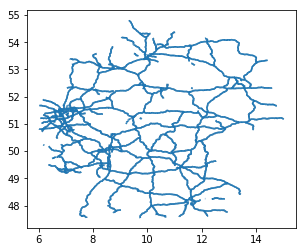

In [28]:
df.plot()

In [41]:
import folium

m = folium.Map(location=[47.5472753, 6.0245327])
folium.GeoJson(fname, name='highways').add_to(m)
folium.LayerControl().add_to(m)
m.save('map.html')

In [30]:
df.total_bounds

array([  6.0245327,  47.5472753,  15.0086389,  54.8058362])